## setup

In [1]:
if not "cdSet" in globals():
    %cd -q ..
    cdSet = True

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import os
from PIL import Image
import matplotlib.pylab as plt

from data.cityscapes import Cityscapes
import models.networks as networks

In [4]:
batch_size = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## data

In [5]:
transforms = transforms.Compose(
            [
                transforms.Resize((512, 512),interpolation=Image.NEAREST),
                transforms.ToTensor(),
            ]
        )

In [6]:
dataset_train = Cityscapes(
    root="../data/cityscapes/",
    split="train",
    mode="fine",
    target_type="semantic",
    transform=None,
    target_transform=None,
    transforms=transforms,
)


dataset_val = Cityscapes(
    root="../data/cityscapes/",
    split="val",
    mode="fine",
    target_type="semantic",
    transform=None,
    target_transform=None,
    transforms=transforms,
)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=2)

In [7]:
dataset_train[0][0].max()

tensor(1.)

## load pre-trained model

In [8]:
netVAE = networks.define_VAE(input_nc=34)
netVAE = netVAE.to(device)

In [13]:
PATH ='../../CelebAMask-HQ/MaskGAN_demo/checkpoint_vae/000070.pt'
checkpoint = torch.load(PATH)
netVAE.load_state_dict(checkpoint['vae'])

<All keys matched successfully>

## sample new masks

In [14]:
inter_lambda = 2.5 #from paper

In [15]:
def vae_interpolation(label_t, label_ref):
    z_t, latent_mu_t, latent_logvar_t = netVAE.get_latent_var(label_t)
    z_ref, latent_mu_ref, latent_logvar_ref = netVAE.get_latent_var(label_ref)

    z_inter = z_t + (z_ref - z_t) / inter_lambda
    z_outer = z_t - (z_ref - z_t) / inter_lambda

    inter_label_1 = netVAE.decode(z_inter)
    inter_label_2 = netVAE.decode(z_outer)

    return inter_label_1, inter_label_2

In [21]:
for batch in dataloader_train:
    image_t, label_t, label_ref = batch
    image_t, label_t, label_ref = (
        image_t.to(device),
        label_t.to(device),
        label_ref.to(device),
    )
    label_t_onehot = F.one_hot(label_t.long(), num_classes=34)
    label_t_onehot = label_t_onehot.permute(0, 3, 1, 2).float().contiguous()
    label_ref_onehot = F.one_hot(label_ref.long(), num_classes=34)
    label_ref_onehot = label_ref_onehot.permute(0, 3, 1, 2).float().contiguous()

    inter_label_1, inter_label_2 = vae_interpolation(label_t_onehot, label_ref_onehot)
    print(inter_label_1.shape, inter_label_2.shape)
    break

torch.Size([8, 34, 512, 512]) torch.Size([8, 34, 512, 512])


## plot interpolated variations

In [22]:
mapping = {
    (0, 0, 0): 0,
    (0, 0, 0): 1,
    (0, 0, 0): 2,
    (0, 0, 0): 3,
    (0, 0, 0): 4,
    (111, 74, 0): 5,
    (81, 0, 81): 6,
    (128, 64, 128): 7,
    (244, 35, 232): 8,
    (250, 170, 160): 9,
    (230, 150, 140): 10,
    (70, 70, 70): 11,
    (102, 102, 156): 12,
    (190, 153, 153): 13,
    (180, 165, 180): 14,
    (150, 100, 100): 15,
    (150, 120, 90): 16,
    (153, 153, 153): 17,
    (153, 153, 153): 18,
    (250, 170, 30): 19,
    (220, 220, 0): 20,
    (107, 142, 35): 21,
    (152, 251, 152): 22,
    (70, 130, 180): 23,
    (220, 20, 60): 24,
    (255, 0, 0): 25,
    (0, 0, 142): 26,
    (0, 0, 70): 27,
    (0, 60, 100): 28,
    (0, 0, 90): 29,
    (0, 0, 110): 30,
    (0, 80, 100): 31,
    (0, 0, 230): 32,
    (119, 11, 32): 33,
    (0, 0, 142): 34,
}

In [23]:
def plot_RGB(image):
    rev_mapping = {mapping[k]: k for k in mapping}
    pred = torch.argmax(image, dim=1) # or e.g. pred = torch.randint(0, 19, (224, 224))
    pred_image = torch.zeros(3, pred.shape[1], pred.shape[2], dtype=torch.uint8)
    for k in rev_mapping:
        pred_image[:, pred[0]==k] = torch.tensor(rev_mapping[k]).byte().view(3, 1)
    plt.imshow(pred_image.permute(1, 2, 0).numpy())

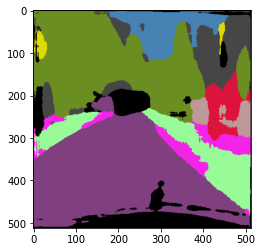

In [24]:
plot_RGB(inter_label_1)

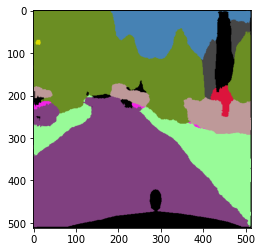

In [25]:
plot_RGB(inter_label_2)

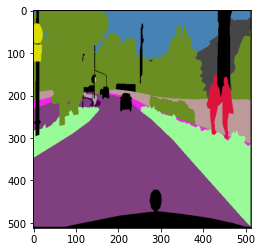

In [26]:
plot_RGB(label_t_onehot)

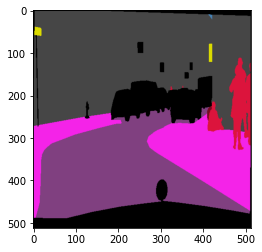

In [27]:
plot_RGB(label_ref_onehot)

## interpolation

In [46]:
netVAE.eval()

def interpolation(lambda1, model, img1, img2):
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encode(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

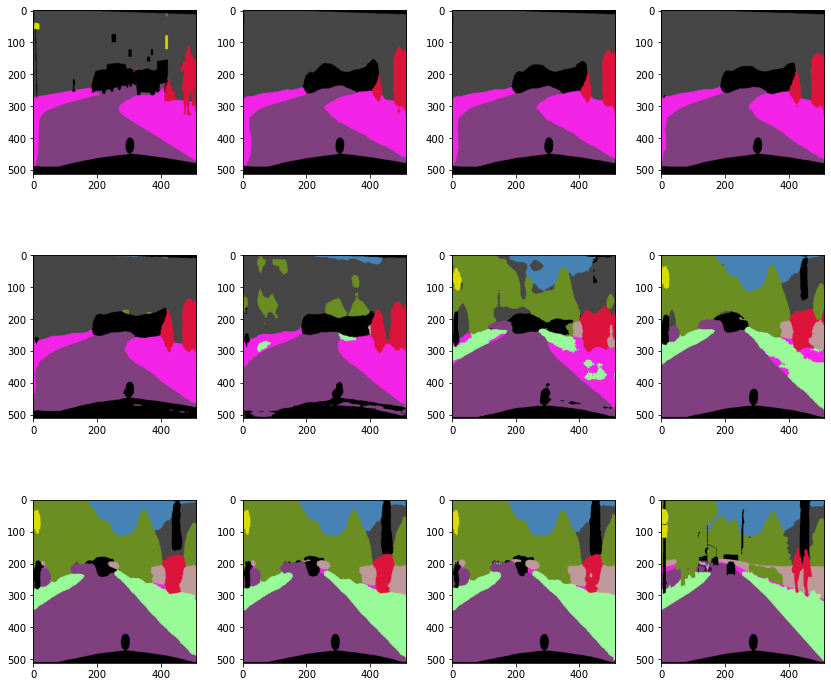

In [54]:
# interpolation lambdas
lambda_range=torch.linspace(0,1,10)

fig, axs = plt.subplots(3,4, figsize=(15, 12))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

rev_mapping = {mapping[k]: k for k in mapping}
pred = torch.argmax(label_t_onehot, dim=1) # or e.g. pred = torch.randint(0, 19, (224, 224))
pred_image = torch.zeros(3, pred.shape[1], pred.shape[2], dtype=torch.uint8)
for k in rev_mapping:
    pred_image[:, pred[0]==k] = torch.tensor(rev_mapping[k]).byte().view(3, 1)
axs[11].imshow(pred_image.permute(1, 2, 0).numpy())

rev_mapping = {mapping[k]: k for k in mapping}
pred = torch.argmax(label_ref_onehot, dim=1) # or e.g. pred = torch.randint(0, 19, (224, 224))
pred_image = torch.zeros(3, pred.shape[1], pred.shape[2], dtype=torch.uint8)
for k in rev_mapping:
    pred_image[:, pred[0]==k] = torch.tensor(rev_mapping[k]).byte().view(3, 1)
axs[0].imshow(pred_image.permute(1, 2, 0).numpy())

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(l.float(), netVAE, label_t_onehot, label_ref_onehot)
    
    rev_mapping = {mapping[k]: k for k in mapping}
    pred = torch.argmax(inter_image, dim=1) # or e.g. pred = torch.randint(0, 19, (224, 224))
    pred_image = torch.zeros(3, pred.shape[1], pred.shape[2], dtype=torch.uint8)
    for k in rev_mapping:
        pred_image[:, pred[0]==k] = torch.tensor(rev_mapping[k]).byte().view(3, 1)
    axs[ind+1].imshow(pred_image.permute(1, 2, 0).numpy())
plt.show() 